In [ ]:
import collections

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
from bs4 import BeautifulSoup

### O que precisa estar no relatório
- for loops, estruturas de repetição;
- estruturas condicionais;
- funções;
- raspagem.

### Unindo os datasets
Unir as notas de bechdel com elenco e equipe com o merge:
- O primeiro parâmetro passado é dataframe da "esquerda" e o segundo, da direita. Os dois próximos parâmetros (`left_on` e `right_on`) dizem quais colunas serão consideradas pra fazer o merge. O `how='inner'` calcula a interseção entre essas duas colunas.

Primeiro é feito o merge do links_df com o bechdel_df, pois bechdel_df não possui o tmdbid diretamente, mas os outros sim.
obs.: o 'id' no `credits.csv` e no `movies_metadata.csv` é o tmdbid.

`reset_index(drop='True')` = reseta os indexes sem criar uma nova coluna para eles.

In [ ]:
bechdel_df = pd.read_csv('data.csv')

# remove colunas não usadas.
bechdel_df = bechdel_df.drop(['Unnamed: 0'], axis=1)

# renomeia rating para não coincidir com o dos outros datasets.
bechdel_df = bechdel_df.rename(columns={'rating': 'bt_score'})

# DESCARTA VALORES VAZIOS e reseta o index.
bechdel_df = bechdel_df[
	(bechdel_df.cast != '[]')
	& (bechdel_df.crew != '[]')
	& (bechdel_df.vote_count != 0)
	& (bechdel_df.vote_average != 0)
	& (bechdel_df.genres != '[]')
	].reset_index(drop='True')

bechdel_df

In [ ]:
total = len(bechdel_df) * 0.01
print('Valores nulos:')
print('Orçamento: %.2f%%' % (len(bechdel_df[bechdel_df.budget == 0])/total))
print('Bilheteria: %.2f%%' % (len(bechdel_df[bechdel_df.revenue == 0])/total))
print('Produtoras: %.2f%%' % (len(bechdel_df[bechdel_df.production_companies == '[]'])/total))
print('Países: %.2f%%' % (len(bechdel_df[bechdel_df.production_countries == '[]'])/total))

# Nulos removidos:
# print('Duração: %.2f%%' % (len(bechdel_df[bechdel_df.runtime == 0])/total))
# print('Número de votos: %.2f%%' % (len(bechdel_df[bechdel_df.vote_count == 0])/total))
# print('Nota média: %.2f%%' % (len(bechdel_df[bechdel_df.vote_average == 0])/total))
# print('Língua: %.2f%%' % (len(bechdel_df[bechdel_df.original_language == 'xx'])/total))
# print('Gênero: %.2f%%' % (len(bechdel_df[bechdel_df.genres == '[]'])/total))


Valores nulos:
Orçamento: 46.54%
Bilheteria: 46.69%
Produtoras: 5.68%
Países: 1.84%


# Gráficos simples

### Filmes por nota no teste de Bechdel
**Métodos utilizados**
- `collections.Counter()`: conta os valores totais das notas de 0 a 3.
- `DataFrame.from_dict(data, orient='index')`: transforma um dicionário em DataFrame. `orient='index'` faz com que as keys do dicionário sejam usadas como index.

[Text(0.5, 1.0, 'Notas dos filmes no teste de Bechdel')]

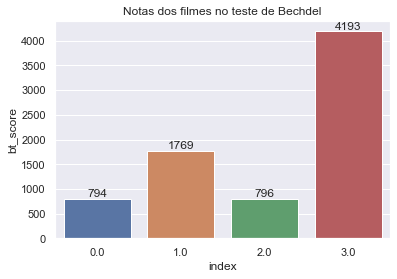

In [ ]:
# TOTAL DE FILMES POR NOTA.
# score_plot = sns.barplot(x='score', y='total', data=score_df)
score_plot = sns.barplot(x='index', y='bt_score', data=bechdel_df.bt_score.value_counts().reset_index())
score_plot.bar_label(score_plot.containers[0])
score_plot.set(title='Notas dos filmes no teste de Bechdel')

[0.0, 1.0, 3.0, 2.0]

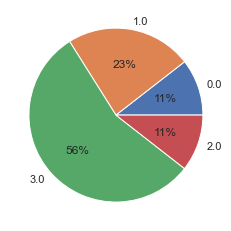

In [ ]:
# PORCENTAGEM DOS FILMES
# score_df = df com a quantidade de filmes por nota.
score_df = collections.Counter(bechdel_df.bt_score)
score_df = pd.DataFrame.from_dict(score_df, orient='index').reset_index()
score_df = score_df.rename(columns={'index': 'score', 0: 'total'})
plt.pie(score_df.total, labels = score_df.score.to_list(), autopct='%.0f%%')
score_df.score.to_list()

<AxesSubplot:>

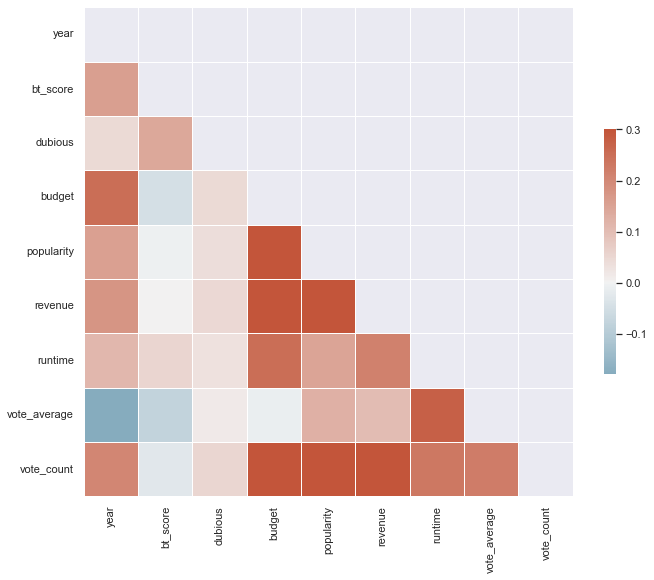

In [ ]:
# GRÁFICO DE CORRELAÇÃO
# num_df = df com todas as colunas de valores numéricos. Exceto os ids.

num_df = bechdel_df[['year', 'bt_score', 'dubious', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]
corr = num_df.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Retirando o gender de cast e crew.
`eval()`: lê uma string e a trata como uma expressão python. Nesse caso, trasforma a string em lista.

In [ ]:
# lst = eval(bechdel_df.cast[0])
for index, row in bechdel_df.iterrows():
	cast = eval(row.cast)
	for person in cast:
		print(person['gender'])
	break


NameError: name 'q' is not defined

In [9]:
data = pd.read_csv('data.csv')
data

,Unnamed: 0,title,year,bt_score,dubious,imdbid,tmdbId,genres,popularity,production_companies,production_countries,release_date,revenue,vote_average,vote_count,cast,crew,budget
0,0,Cinderella,1899,3,0,230,114108,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",3.762,"[{'id': 7159, 'logo_path': None, 'name': 'Star...","[{'iso_3166_1': 'FR', 'name': 'France'}]",1899-10-01,0.0,6.1,79.0,"[{'adult': False, 'gender': 2, 'id': 11523, 'k...","[{'adult': False, 'gender': 2, 'id': 11523, 'k...",0.0
1,1,Gretchen the Greenhorn,1916,3,0,6745,126925,[],1.942,[],[],1916-09-03,0.0,6.1,7.0,"[{'adult': False, 'gender': 1, 'id': 30779, 'k...","[{'adult': False, 'gender': 2, 'id': 42060, 'k...",0.0
2,2,Snow White,1916,3,0,7361,174598,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",0.817,[],[],1916-12-24,0.0,5.7,9.0,"[{'adult': False, 'gender': 0, 'id': 1658947, ...","[{'adult': False, 'gender': 2, 'id': 28968, 'k...",0.0
3,3,The Poor Little Rich Girl,1917,3,0,8443,95866,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",2.023,"[{'id': 13400, 'logo_path': None, 'name': 'Art...","[{'iso_3166_1': 'US', 'name': 'United States o...",1917-03-05,0.0,5.8,23.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 2, 'id': 13335, 'k...",0.0
4,4,Stella Maris,1918,3,0,9652,70753,"[{'id': 18, 'name': 'Drama'}]",1.310,"[{'id': 21540, 'logo_path': None, 'name': 'Mar...","[{'iso_3166_1': 'US', 'name': 'United States o...",1918-01-21,2400000.0,6.9,19.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 1, 'id': 34741, 'k...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7332,7630,Sand Castle,2017,0,0,2582576,390054,"[{'id': 10752, 'name': 'War'}, {'id': 28, 'nam...",31.004,"[{'id': 1557, 'logo_path': '/ccz9bqCu3jSFKbPFn...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2017-04-21,0.0,6.5,631.0,"[{'adult': False, 'gender': 2, 'id': 130253, '...","[{'adult': False, 'gender': 1, 'id': 5914, 'kn...",0.0
7333,7631,Diary of a Wimpy Kid: The Long Haul,2017,0,0,6003368,417830,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",17.122,"[{'id': 25, 'logo_path': '/qZCc1lty5FzX30aOCVR...","[{'iso_3166_1': 'US', 'name': 'United States o...",2017-05-19,40120144.0,5.3,355.0,"[{'adult': False, 'gender': 2, 'id': 1517834, ...","[{'adult': False, 'gender': 2, 'id': 1999, 'kn...",22000000.0
7334,7632,God's Own Country,2017,0,0,5635086,428493,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",16.294,"[{'id': 7281, 'logo_path': '/lkqIuaKTm2sg3umwT...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2017-09-01,2559939.0,7.8,715.0,"[{'adult': False, 'gender': 2, 'id': 1206334, ...","[{'adult': False, 'gender': 1, 'id': 2635, 'kn...",0.0
7335,7633,MFKZ,2017,0,0,4717402,461615,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",7.712,"[{'id': 21660, 'logo_path': '/mog3VrjYLXvWDocE...","[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",2018-05-23,461724.0,7.1,222.0,"[{'adult': False, 'gender': 2, 'id': 1265647, ...","[{'adult': False, 'gender': 1, 'id': 90162, 'k...",0.0
